# Description

Perform asset optimization 


Methods : 
* Equally weighted
* 
* 
* 


**NE PAS OUBLIER**
* FAIRE LA RACINE CARREE SUR LA VOLATILITE POUR CALCULER LE RISQUE
* Implémentation rebalancement
* implémentation tracking error (voir https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/tracking-error/)
* astuce de modelisation gurobipy
    * https://support.gurobi.com/hc/en-us/community/posts/360074491212-Divisor-must-be-a-constant
    * http://yetanothermathprogrammingconsultant.blogspot.com/2016/08/portfolio-optimization-maximize-sharpe.html

# Setup

In [1]:
%matplotlib notebook
%load_ext autoreload

## Imports

In [2]:
# os related
from pathlib import Path
import os 

# data related
import pandas as pd
import missingno as msno
import datetime as dt
import numpy as np

# optimization related
from gurobipy import (Model, GRB, quicksum, multidict, tuplelist)

# visual related
import matplotlib.pyplot as plt
import seaborn as sns

# time related


In [3]:

from fonctions import *

## Paths

In [47]:
# MUST BE IN CODE FOLDER TO WORK !
PROJECT_PATH = Path(os.getcwd()).parent

RAW_DATA = PROJECT_PATH / "RAW_DATA" 
PROC_DATA = PROJECT_PATH / "PROC_DATA"

# RAW FILES
CSV_FILE = RAW_DATA / "Individual_stock_data_csv.csv"
XLSX_FILE = RAW_DATA / "Individual_stock_data.xlsx"

# PROC FILES
PROC_STOCK = PROC_DATA / "proc_stock.csv"
PROC_CARBON = PROC_DATA / "proc_carbon.csv"

STOCK_2000 = PROC_DATA / "stock_2000.csv"


STOCK_WORK = PROC_DATA / "stock_work.csv"
STOCK2USE = PROC_DATA / "stock2use.csv"
DIC2USE = PROC_DATA / "dic2use.json"


OUT_DF_CSV = PROC_DATA / "optimize_assets.csv"

## Utils

# Notebook

## Loading data

In [5]:
df = read_file(STOCK2USE)

In [6]:
carbon_df = read_file(PROC_CARBON, index="company")

## EW

In [7]:
mean, std = equally_weighted(df) # correct std function in fonctions.py 

ValueError: too many values to unpack (expected 2)

In [7]:
weeks = 12
nb_period = len(df)//12

In [8]:
# df_period = 

# compute_weights(df_period, method)
# apply weights
# compute(return and risk)
# compute

SyntaxError: invalid syntax (<ipython-input-8-bcfbd5648b73>, line 1)

<IPython.core.display.Javascript object>


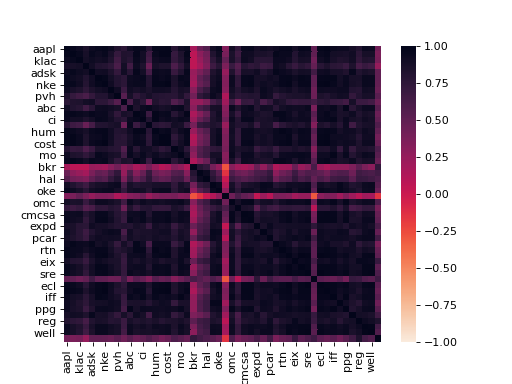

<AxesSubplot:>

In [9]:

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="rocket_r")


## GMV

In [10]:
cov = df.cov().to_numpy()

In [11]:
def gmv(cov, nb_weights=50):
    """Function that computes weights for global minimum volatility
    Parameters:
    cov(matrix):covariance of data
    nb_weights(int):number of weights to optimize
    Returns:
    weights(list)"""
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)

    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids

    # Contraintes
    model.addConstr(w.sum() == 1)
    

    obj = np.dot(vecw_col.T,np.dot(cov, vecw_col))
    model.setObjective(obj[0][0])

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    
    return opt_w

    
    

In [12]:
model = Model()

model.modelSense = GRB.MINIMIZE

# Définir poids
w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)

arr = np.array(w.select("*"))
vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids

# Contraintes
model.addConstr(w.sum() == 1)
    

obj = np.dot(vecw_col.T,np.dot(cov, vecw_col))
model.setObjective(obj[0][0])


model.update()
model.optimize()


Using license file c:\gurobi912\gurobi.lic
Set parameter TokenServer to value dev.cma.mines-paristech.fr
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x00bc056b
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+04, 1e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective         

In [13]:
opt_w = [w[i].x for i in range(len(w))]

In [14]:
max_weight = max(opt_w)
opt_w.index(max_weight)

20

In [15]:
df.columns[20]
# carbon_df.loc["bkr"]
# df.std().sort_values()

'bkr'

## Max Decor

In [16]:
cor = df.corr().to_numpy()

<IPython.core.display.Javascript object>


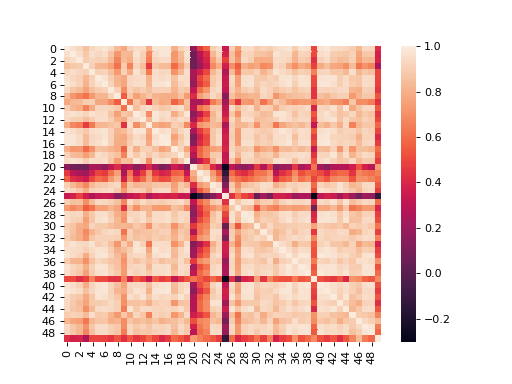

<AxesSubplot:>

In [17]:
plt.figure()
sns.heatmap(cor)

In [18]:
def max_decor(corr, nb_weights=50):
    model = Model()

    model.modelSense = GRB.MINIMIZE

    # Définir poids
    w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
    arr = np.array(w.select("*"))
    vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids
    # Contraintes
    model.addConstr(w.sum() == 1)
    obj = np.dot(vecw_col.T,np.dot(corr, vecw_col))
    model.setObjective(obj[0][0])
    
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w =  [w[i].x for i in range(len(w))]
    return opt_w
    
    
    
    

In [19]:
model = Model()

model.modelSense = GRB.MINIMIZE

# Définir poids
w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)

arr = np.array(w.select("*"))
vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids

# Contraintes
model.addConstr(w.sum() == 1)
    

obj = np.dot(vecw_col.T,np.dot(cor, vecw_col))
model.setObjective(obj[0][0])


model.update()
model.optimize()


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0xb18d5bd9
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.29621894e+05 -2.29621894e+05  1.94e+04 8.96e-04  2.50e+05     0s
   1   1.16232561e+05 -1.16716493e+05  1.70e+03 7

In [20]:
opt_w = [w[i].x for i in range(len(w))]

max_weight = max(opt_w)
max_idx = opt_w.index(max_weight)




In [21]:
df.columns[max_idx]

'ipg'

<IPython.core.display.Javascript object>


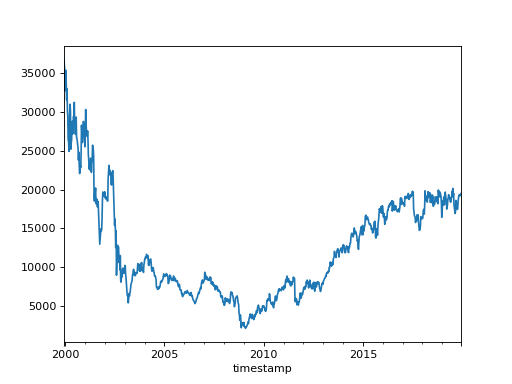

<AxesSubplot:xlabel='timestamp'>

In [22]:
plt.figure()
df["ipg"].plot()

In [23]:
carbon_df.loc["ipg"]

name                     INTERPUBLIC GROUP
sector                                  50
sector_name         Communication Services
scope1                              2.2577
scope2                             20.9515
emissions                          23.2092
market_value                        8941.1
revenues                            9714.4
carbon_footprint                  2.595788
intensity                         2.389154
Name: ipg, dtype: object

In [24]:
df.corr()[["ipg"]].describe().quantile()

ipg    0.300181
Name: 0.5, dtype: float64

In [25]:
for weight in sorted(opt_w, reverse=True):
    idx = opt_w.index(weight)
    print(df.columns[idx])

ipg
exc
bkr
pvh
slb
gww
mck
kim
well
fmc
nvda
ed
cvx
hal
el
intu
abc
syy
aapl
bby
oke
shw
nke
ppg
mo
expd
ecl
unh
has
tif
pcar
sre
cost
ba
avb
viac
es
iff
klac
reg
wba
rtn
adsk
hum
cmcsa
dis
eix
pld
ci
omc


In [26]:
df.corr()[["omc"]].describe()

,omc
count,50.000000
mean,0.852796
std,0.147508
min,0.321145
25%,0.854793
50%,0.902291
75%,0.935217
max,1.000000


In [27]:
carbon_df.loc["omc"]

name                         OMNICOM GROUP
sector                                  50
sector_name         Communication Services
scope1                              23.961
scope2                              77.445
emissions                          101.406
market_value                       17904.1
revenues                           15290.2
carbon_footprint                  5.663842
intensity                         6.632091
Name: omc, dtype: object

## Max div

In [28]:
def max_div(cov, nb_weights=50):
    
    
    model = Model()
    model.modelSense = GRB.MINIMIZE
    y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1)) 

    strd = np.sqrt(np.diag(cov))
    
    yp = np.dot(vecy_col.T,np.reshape(strd,(len(strd),1)))

    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance

    model.setObjective(obj)
    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()
    
    opt_w = [y[i].x /y.sum().getValue() for i in range(len(y))]
    
    return opt_w

In [29]:
# Astuce de modélisation Sharp Ratio
# y est utilisée pour la transformation du problème

model = Model()
model.modelSense = GRB.MINIMIZE

# Définir poids
y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS)
arr = np.array(y.select("*"))
vecy_col = np.reshape(arr, (len(arr), 1)) 

# les deux sont idems
std = np.sqrt(np.diag(cov))
# df.std().values()

yp = np.dot(vecy_col.T,np.reshape(std,(len(std),1)))

port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

model.addConstr(yp[0][0] == 1)
obj = port_variance

model.setObjective(obj)

model.update()
model.optimize()


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0xd903476c
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+02, 6e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+04, 1e+10]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.612186

In [30]:
xopt = [y[i].x /y.sum().getValue() for i in range(len(y))]

In [31]:
xopt

[1.1455031222115627e-12,
 7.769067346822406e-12,
 2.6307393299983953e-12,
 7.728265540425182e-12,
 1.179053308664057e-12,
 4.342777643187244e-13,
 6.875739630272666e-13,
 6.249119130146685e-12,
 0.0006456861615676851,
 1.3262737199467913e-12,
 1.5410856222156002e-11,
 2.3654607759207753e-13,
 3.4840228075352223e-12,
 1.159523947303866e-10,
 1.6828660241518595e-13,
 3.1979402090430544e-11,
 1.4071338355565394e-11,
 3.3379858231301407e-13,
 3.0211138639619473e-13,
 1.226328971298304e-12,
 0.917834456438605,
 0.00013543404382178144,
 3.32983198614939e-11,
 4.7325232952334416e-12,
 1.1926479605877473e-12,
 0.03114473386625849,
 7.250677745173084e-13,
 6.635780629782476e-11,
 1.5850272031558424e-13,
 3.644344294248386e-12,
 1.2118797073942205e-12,
 2.7339765971245393e-11,
 9.435070085813021e-13,
 3.5431180742544467e-13,
 1.2522777642746303e-12,
 5.476830002521697e-12,
 2.29864124173509e-12,
 3.748585988567044e-12,
 2.1082142419754417e-12,
 0.050239688919846766,
 3.1713841920838785e-12,
 6.1

## MSR

In [32]:
def msr(mu, cov, nb_weights=50):
    
    model = Model()
    model.modelSense = GRB.MINIMIZE

    y = model.addVars(nb_weights, vtype=GRB.CONTINUOUS)
    arr = np.array(y.select("*"))
    vecy_col = np.reshape(arr, (len(arr), 1))

    yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))
    port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]

    model.addConstr(yp[0][0] == 1)
    obj = port_variance

    model.setObjective(obj)

    model.setParam('OutputFlag', 0) # Mute output
    model.update()
    model.optimize()

    opt_w = [y[i].x for i in range(len(y))]
    
    return opt_w
    
    

**deprecated**

In [ ]:
# Astuce de modélisation Sharp Ratio
# y est utilisée pour la transformation du problème
# xVar et yVar pour modéliser la racine carrée

model = Model()
model.modelSense = GRB.MINIMIZE


# Définir poids
y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
arr = np.array(y.select("*"))
vecy_col = np.reshape(arr, (len(arr), 1)) 

mu = df.pct_change().mean().tolist()
yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))

xVar = model.addVar(vtype=GRB.CONTINUOUS)
yVar = model.addVar(vtype=GRB.CONTINUOUS)

port_variance = np.dot(vecy_col.T,np.dot(cov, vecy_col))[0][0]
model.addConstr(xVar == port_variance)
model.addGenConstrPow(xVar, yVar, 0.5)


model.addConstr(yp[0][0] == 1)
    

model.setParam("Nonconvex", 2)

    
obj = 1 / yVar


model.setObjective(obj)


model.update()
model.optimize()


In [ ]:
# puisque Q est semi-définie positive on obtient la chose suivante

In [ ]:
# Rajouter taux sans risque

In [33]:
# Astuce de modélisation Sharp Ratio
# y est utilisée pour la transformation du problème
# xVar et yVar pour modéliser la racine carrée

model = Model()
model.modelSense = GRB.MINIMIZE


# Définir poids
y = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS)
arr = np.array(y.select("*"))
vecy_col = np.reshape(arr, (len(arr), 1)) 

mu = df.pct_change().mean().tolist()
yp = np.dot(vecy_col.T,np.reshape(mu,(len(mu),1)))


port_variance = np.dot(vecy_col.T,np.dot(cor, vecy_col))[0][0]


model.addConstr(yp[0][0] == 1)    
obj = port_variance


model.setObjective(obj)


model.update()
model.optimize()



Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x348cdfff
Model has 1275 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-04, 7e-03]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 1275 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.45173358e+05 -1.45173358e+05  1.90e+04 5.58e-03  9.74e+05     0s
   1   4.23471840e+05 -4.16884556e+05  1.89e+03 5

In [34]:
[y[i].x for i in range(len(y))]

[3.665773817371228e-10,
 1.1321054016371992e-11,
 8.529081025114394e-12,
 125.51335628846931,
 1.2754979190456365e-11,
 8.116230414957767e-12,
 1.700761516244085e-11,
 9.812708833770737e-12,
 6.821568616130999e-11,
 5.99207368725996e-12,
 8.617046406915487e-11,
 1.3568225449352052e-11,
 9.593945140213174e-12,
 7.963778880376472e-11,
 2.9703119010778275e-11,
 8.797352955414786e-12,
 8.711546549551879e-12,
 1.1061463715979501e-11,
 2.484004985095002e-11,
 5.374576779840144e-12,
 29.54505464453301,
 9.564159622028214e-11,
 4.167137432170564e-11,
 9.36102646897017e-12,
 1.8313258711590258e-11,
 3.361323528688432e-11,
 8.438989816306629e-12,
 1.7004011909988696e-11,
 6.9665023924666335e-12,
 1.0149543598196404e-11,
 8.490323558699344e-12,
 1.6444090577184523e-11,
 2.3508014204374676e-11,
 6.307257144341274e-12,
 7.069833235549976e-12,
 7.342465866505831e-12,
 1.1678559652348708e-11,
 6.956971714992417e-12,
 1.3341163117089595e-11,
 9.488878369328514e-12,
 1.0006605659075305e-11,
 1.82496676

In [35]:
xopt = [y[i].x /y.sum().getValue() for i in range(len(y))]

In [ ]:
model = Model()

model.modelSense = GRB.MINIMIZE

# Définir poids
w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
arr = np.array(w.select("*"))
vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids


xVar = model.addVar(vtype=GRB.CONTINUOUS)
yVar = model.addVar(vtype=GRB.CONTINUOUS)

port_variance = np.dot(vecw_col.T,np.dot(cor, vecw_col))[0][0]

model.addConstr(xVar == port_variance)

model.addGenConstrPow(xVar, yVar, 0.5)


model.addConstr(w.sum() == 1)
    

model.setParam("Nonconvex", 2)
    
obj = yVar
model.setObjective(obj)


model.update()
model.optimize()


Changed value of parameter Nonconvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 52 columns and 50 nonzeros
Model fingerprint: 0xc75e2ee5
Model has 1 quadratic constraint
Model has 1 general constraint
Variable types: 52 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve added 3 rows and 1101 columns
Presolve time: 0.00s
Presolved: 5055 rows, 2428 columns, 14679 nonzeros
Presolved model has 1 SOS constraint(s)
Presolved model has 1275 bilinear constraint(s)
Variable types: 2428 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


 309990 217578    0.21207  117 1081    0.22663    0.09316  58.9%  70.2  410s
 313601 220248    0.22309  151 1175    0.22663    0.09336  58.8%  70.1  415s


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


 321679 225786    0.19971  134 1275    0.22663    0.09381  58.6%  70.1  425s


In [ ]:
# On enlève la racine carree

In [ ]:
model = Model()

model.modelSense = GRB.MINIMIZE

# Définir poids
w = model.addVars(len(df.columns), vtype=GRB.CONTINUOUS, ub=1)
arr = np.array(w.select("*"))
vecw_col = np.reshape(arr, (len(arr), 1)) # vecteur colonne des poids


# xVar = model.addVar(vtype=GRB.CONTINUOUS)
# yVar = model.addVar(vtype=GRB.CONTINUOUS)

mu = df.pct_change().mean().tolist()
Rp = np.dot(vecw_col.T,np.reshape(mu,(len(mu),1)))
rf = 0.01

portvar = np.dot(vecw_col.T,np.dot(cor, vecw_col))[0][0]

# model.addConstr(xVar == port_variance)
# model.addGenConstrPow(xVar,yVar,0.5)

model.addConstr(w.sum() == 1)
    
# model.setParam("Nonconvex", 2)
    
obj = (Rp - rf) * (1 /portvar)
model.setObjective(obj)

model.update()
model.optimize()


** fonction de rebalancement ** 


In [36]:
df

,aapl,intu,klac,nvda,adsk,has,nke,tif,pvh,bby,...,ecl,shw,iff,fmc,ppg,pld,reg,avb,well,kim
timestamp,,,,,,,,,,,,,,,,,,,,,
1999-12-14,723.14,1052.36,3570.27,188.89,1732.45,12798.09,3639.86,2229.50,820.23,12932.70,...,1321.58,2563.78,522.75,2291.15,4581.13,91.32,162.15,209.19,2293.00,366.31
1999-12-21,781.26,1041.73,4664.87,215.88,1796.35,11551.52,4460.95,2326.31,833.24,11866.08,...,1397.02,2571.97,546.18,2253.14,4493.78,95.24,170.54,224.67,2418.78,401.48
1999-12-28,748.39,1109.05,4691.89,226.04,1807.00,12091.70,4540.41,2493.73,807.21,11899.41,...,1460.30,2645.69,553.74,2418.73,4784.95,96.48,172.64,234.30,2322.03,399.28
2000-01-04,781.26,1150.39,4491.89,231.43,1803.45,11468.42,4131.77,2319.26,781.17,15299.24,...,1433.10,2539.20,531.06,2359.01,4498.63,96.79,167.92,225.51,2370.40,401.05
2000-01-11,706.94,1556.69,4997.30,210.80,1710.92,11219.11,4642.57,2458.48,716.07,14899.26,...,1569.81,2531.01,550.91,2511.03,4804.36,100.20,174.21,239.10,2602.61,423.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12,64259.93,10705.25,26537.44,13861.57,37195.60,98409.38,84014.56,9375.33,11098.04,63992.09,...,18624.54,107804.80,3039.61,42682.85,33900.81,964.48,1406.80,3192.37,47500.63,2019.03
2019-11-19,65322.11,11210.91,26904.27,13754.43,38718.16,99295.50,87872.63,9326.25,11249.25,64136.77,...,18734.31,107450.90,3186.75,42292.26,33520.81,1013.47,1416.35,3315.64,49122.66,2110.59
2019-11-26,64831.50,10948.20,24785.44,14350.27,40193.65,104705.90,87609.81,10060.26,11465.47,69421.88,...,18417.84,107999.10,3303.15,42756.63,33760.27,1027.94,1404.41,3293.49,48810.95,2101.82


## Rebalancement

In [37]:
# de la semaine 0 à la semaine 103

# output dataframe
cols= ["ew", "gmv", "maxdecor", "maxdiv", "msr"]
out_df = pd.DataFrame(index=range(nb_period), columns=cols)

nb_period = (len(df) - 104) // 12
for i in range((nb_period)):
    
    
    # retrieve data
    temp_df = df.iloc[0+i*12:104+i*12]
    # print(temp_df.index[0],"->",temp_df.index[-1], len(temp_df))
    mu = temp_df.pct_change().mean() # Vérifier s'il faut enlever les Nans
    cov = temp_df.cov()
    std = temp_df.std()
    corr = temp_df.corr()

    
    # Train
    w_gmv = gmv(cov)
    w_mdecor = max_decor(corr)
    w_mdiv = max_div(cov)
    w_msr = msr(mu.values, cov)

    
    # Test
    test_period = df.iloc[104+i*12:104+(i+1)*12]    
    test_mu = test_period.pct_change().mean()
    
    out_df["gmv"].iloc[i] = (test_mu * w_gmv).sum() * 100
    out_df["maxdecor"].iloc[i] = (test_mu * w_mdecor).sum() * 100
    out_df["maxdiv"].iloc[i] = (test_mu * w_mdiv).sum() * 100
    out_df["msr"].iloc[i] = (test_mu * w_mdiv).sum() * 100
    out_df["ew"].iloc[i] = (test_mu.sum() / len(test_period.columns)) * 100
    
    

<IPython.core.display.Javascript object>


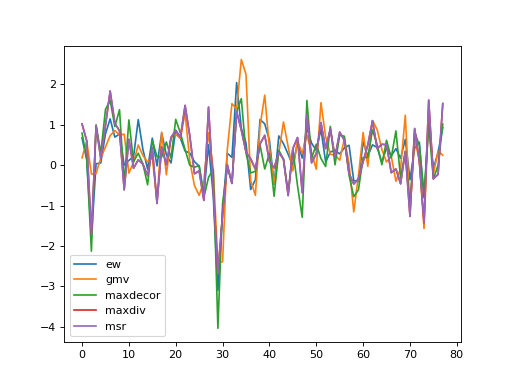

<AxesSubplot:>

In [39]:

out_df.plot()



Sur les 1 an
* Rendement portefeuille (annualisé) 
* Risque du portefeuille (annualisé)
* tracking error 
* mu / sigma
* mup - mub (ecés par rapport au benchmark)
* (mup - mub) / tracking error
* EnC / 50 (50%)